In [1]:
import glob
import os
import re
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import phyphy
from Bio import SeqIO

### Count statistics

In [2]:
absrel = glob.glob("families_absrel/*.ABSREL.log")

In [3]:
ps_list =[]
tot_list = []
fam_list = [] 

for file in absrel:
    with open(file) as myfile:
        for line in myfile:
            if "Likelihood" in line:
                ps, tot, fam = line[117:122].strip("*"), line[155:159].strip("*"), file[16:].split(".")[0]
                ps_list.append(ps)
                tot_list.append(tot)
                fam_list.append(fam)
                
                
df = pd.DataFrame({"family": fam_list,'ps': ps_list, 'total': tot_list})

In [4]:
df[["ps", "total"]] =df[["ps", "total"]].astype("int64") 

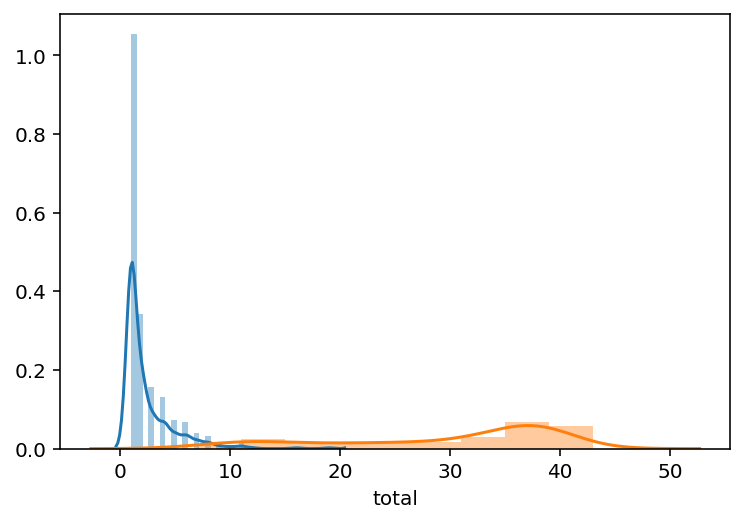

In [5]:
sns.distplot(df['ps']);
sns.distplot(df['total'])

In [6]:
df["ratio"] = df["ps"]/df["total"]

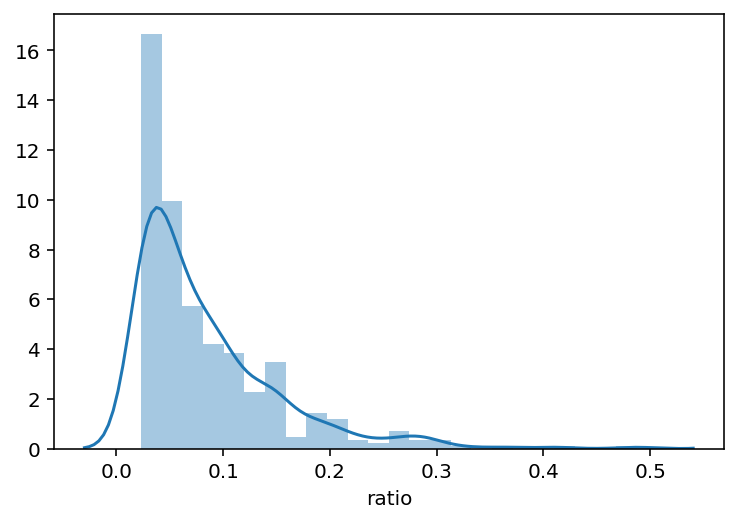

In [7]:
sns.distplot(df["ratio"])

### Parsing of **ABSREL** results

In [8]:
family_list = []
branch_list = []
pvalue_list = []

In [9]:
for file in absrel:
    with open(file) as myfile:
        for line in myfile:
            if re.search(r'^\* \w.+ p-value',line):
                family, branch, pvalue = file[16:].split(".")[0], line[2:].split(",")[0],line.split()[-1]
                family_list.append(family)
                branch_list.append(branch)
                pvalue_list.append(pvalue)

ps = pd.DataFrame({"family": family_list,'branch': branch_list, 'p-value': pvalue_list})

In [10]:
ps

,family,branch,p-value
0,family_19874,Node28,0.00012
1,family_19874,XP_014181204_1,0.00456
2,family_3151,Node32,0.00000
3,family_3151,Node22,0.03763
4,family_3151,Node13,0.03782
...,...,...,...
1018,family_16398,Node33,0.03517
1019,family_19613,XP_007266095_1,0.00001
1020,family_18702,XP_012046577_1,0.04644
1021,family_353,Node19,0.03602


Count plot of the branches under positive selection.

In [12]:
absrel_json = glob.glob("families_absrel/*.ABSREL.json")

In [13]:
tree_list=[]
family_list=[]

for file in absrel_json:
    tree,family = phyphy.Extractor(file).extract_input_tree(),file[16:].split(".")[0]
    tree_list.append(tree)
    family_list.append(family)
    
tdf = pd.DataFrame({"tree":tree_list,"family":family_list})

In [14]:
tdf

,tree,family
0,"(EUC63301_1:0.7495534109999999,(KTB33848_1:0.4...",family_15978
1,"(SAM78657_1:0.015190214,CCF54372_1:0.02004617,...",family_2650
2,"(KTB34652_1:0.266200738,(XP_007266876_1:0.1751...",family_5016
3,"(XP_014568860_1:0.454027993,XP_016270687_1:0.4...",family_2688
4,"(EUC55673_1:0.100956782,((XP_014178320_1:0.124...",family_16314
...,...,...
427,"(XP_014565519_1:0.5006961720000001,(XP_0074094...",family_13640
428,"(((XP_011388098_1:0.032369773,(SJX61523_1:0.01...",family_13914
429,"((EUC67484_1:0.376524457,((SJX66190_1:0.020156...",family_3014
430,"(CCA68757_1:0.447275444,(EUC59754_1:0.50851876...",family_2627


Getting daughter leaves can be done using `ete3` package.

In [15]:
from ete3 import Tree

Make for loop that reads the tree in the ete3 package and names them according to the family

In [16]:
t = Tree(tdf.tree[0], format=1)

In [17]:
for node in t.iter_descendants("postorder"):
    print(node.name)

EUC63301_1
KTB33848_1
KIJ14911_1
Node2
XP_007271835_1
XP_014566825_1
KIR57886_1
XP_012048787_1
Node10
SJX61700_1
SAM80347_1
CCF53572_1
Node15
Node13
Node9
Node7
Node5


To get the descendant leave nodes this can be used:

In [18]:
t = Tree(tdf.tree[0], format=1)

node = t.search_nodes(name="Node4")[0]


for n in node.iter_descendants("postorder"):
    if n.is_leaf():
        print(n.name)

IndexError: list index out of range

The next step is to write a loop that takes all nodes and then replaces them or makes a new column with the resulting list of leaf nodes

First I need to actually merge the two previous dataframes

In [19]:
ps = ps.merge(tdf)

In [20]:
ps.to_csv("ps.csv")

In [21]:
t_test = Tree(ps.tree[300], format=1)
node_test = t_test.search_nodes(name=ps.branch[300])[0]
node_test.get_leaf_names()

['XP_018740820_1']

In [22]:
children_list=[]

for i in range(0,len(ps)):
    t = Tree(ps.tree[i], format=1)
    node = t.search_nodes(name=ps.branch[i])[0]
    children_list.append(node.get_leaf_names())
        

In [23]:
ps["children"] = children_list

This way I only get the leaf names in a list within each cell in the dataframe. I need to separate the list to be able to plot it.

Convert to long form, so that every item in the list corresponds to one row.

In [25]:
lst_col = 'children'

r = pd.DataFrame({
      col:np.repeat(ps[col].values, ps[lst_col].str.len())
      for col in ps.columns.drop(lst_col)}
    ).assign(**{lst_col:np.concatenate(ps[lst_col].values)})[ps.columns]

In [26]:
r

,family,branch,p-value,tree,children
0,family_19874,Node28,0.00012,"((XP_007271163_1:0.294216738,((KIJ13771_1:0.39...",XP_014181204_1
1,family_19874,Node28,0.00012,"((XP_007271163_1:0.294216738,((KIJ13771_1:0.39...",KIR67697_1
2,family_19874,Node28,0.00012,"((XP_007271163_1:0.294216738,((KIJ13771_1:0.39...",XP_012048144_1
3,family_19874,XP_014181204_1,0.00456,"((XP_007271163_1:0.294216738,((KIJ13771_1:0.39...",XP_014181204_1
4,family_3151,Node32,0.00000,"(CCA71270_1:0.6925800989999999,(XP_007265603_1...",XP_007418601_1
...,...,...,...,...,...
3339,family_353,Node19,0.03602,"((EUC54641_1:0.810694861,(XP_007262729_1:0.453...",SAM84633_1
3340,family_353,Node19,0.03602,"((EUC54641_1:0.810694861,(XP_007262729_1:0.453...",CCF48913_1
3341,family_2123,Node14,0.00571,"(XP_027482623_1:1.227699243,(EUC54576_1:0.6511...",XP_014176898_1
3342,family_2123,Node14,0.00571,"(XP_027482623_1:1.227699243,(EUC54576_1:0.6511...",KIR67571_1


In [27]:
r_dd = r.drop_duplicates(subset=['family', 'children'])

In [28]:
r_dd

,family,branch,p-value,tree,children
0,family_19874,Node28,0.00012,"((XP_007271163_1:0.294216738,((KIJ13771_1:0.39...",XP_014181204_1
1,family_19874,Node28,0.00012,"((XP_007271163_1:0.294216738,((KIJ13771_1:0.39...",KIR67697_1
2,family_19874,Node28,0.00012,"((XP_007271163_1:0.294216738,((KIJ13771_1:0.39...",XP_012048144_1
4,family_3151,Node32,0.00000,"(CCA71270_1:0.6925800989999999,(XP_007265603_1...",XP_007418601_1
5,family_3151,Node32,0.00000,"(CCA71270_1:0.6925800989999999,(XP_007265603_1...",POV94377_1
...,...,...,...,...,...
3339,family_353,Node19,0.03602,"((EUC54641_1:0.810694861,(XP_007262729_1:0.453...",SAM84633_1
3340,family_353,Node19,0.03602,"((EUC54641_1:0.810694861,(XP_007262729_1:0.453...",CCF48913_1
3341,family_2123,Node14,0.00571,"(XP_027482623_1:1.227699243,(EUC54576_1:0.6511...",XP_014176898_1
3342,family_2123,Node14,0.00571,"(XP_027482623_1:1.227699243,(EUC54576_1:0.6511...",KIR67571_1


Replace by species. To do this I need to make a dictionary, like I did for the supertree. Then transform into dataframe. Then merge with r_dd dataframe. This step takes quite a while

In [29]:
files = os.listdir("faas/")

taxa=[]
for file in files:
    if file.endswith(".faa"):
        taxa.append(file.split(".")[0])
empty_dict={}
for t in taxa:
    test = SeqIO.to_dict(SeqIO.parse("faas/"+t+".faa","fasta"))
    for key,value in test.items():
        test[key] = t
        empty_dict.update(test)

Made the dictionary, called it empty_dict. Need to convert now to a dataframe and merge to r_dd.

In [30]:
spec_name= pd.DataFrame.from_dict(empty_dict,orient='index',
                       columns=["species"])

In [31]:
spec_name

,species
CCF47883.1,Ustilago_hordei
CCF47884.1,Ustilago_hordei
CCF47885.1,Ustilago_hordei
CCF47886.1,Ustilago_hordei
CCF47889.1,Ustilago_hordei
...,...
YP_009517878.1,Malassezia_restricta
YP_009517879.1,Malassezia_restricta
YP_009517880.1,Malassezia_restricta
YP_009517881.1,Malassezia_restricta


In [32]:
spec_name["children"]=spec_name.index

In [33]:
spec = spec_name.replace("\.","_",regex=True)

In [34]:
r_dd = r_dd.merge(spec)

[Text(0, 0, 'Trichosporon_asahii'),
 Text(0, 0, 'Cryptococcus_gattii'),
 Text(0, 0, 'Cryptococcus_neoformans'),
 Text(0, 0, 'Melampsora_larici-populina'),
 Text(0, 0, 'Puccinia_striiformis'),
 Text(0, 0, 'Puccinia_triticina'),
 Text(0, 0, 'Malassezia_globosa'),
 Text(0, 0, 'Malassezia_restricta'),
 Text(0, 0, 'Ustilago_maydis'),
 Text(0, 0, 'Sporisorium_reilianum'),
 Text(0, 0, 'Ustilago_bromivora'),
 Text(0, 0, 'Ustilago_hordei'),
 Text(0, 0, 'Piloderma_croceum'),
 Text(0, 0, 'Moniliophthora_roreri'),
 Text(0, 0, 'Paxillus_involutus'),
 Text(0, 0, 'Rhizoctonia_solani'),
 Text(0, 0, 'Rhodotorula_toruloides'),
 Text(0, 0, 'Mixia_osmundae'),
 Text(0, 0, 'Malassezia_sympodialis'),
 Text(0, 0, 'Serendipita_indica'),
 Text(0, 0, 'Fomitiporia_mediterranea')]

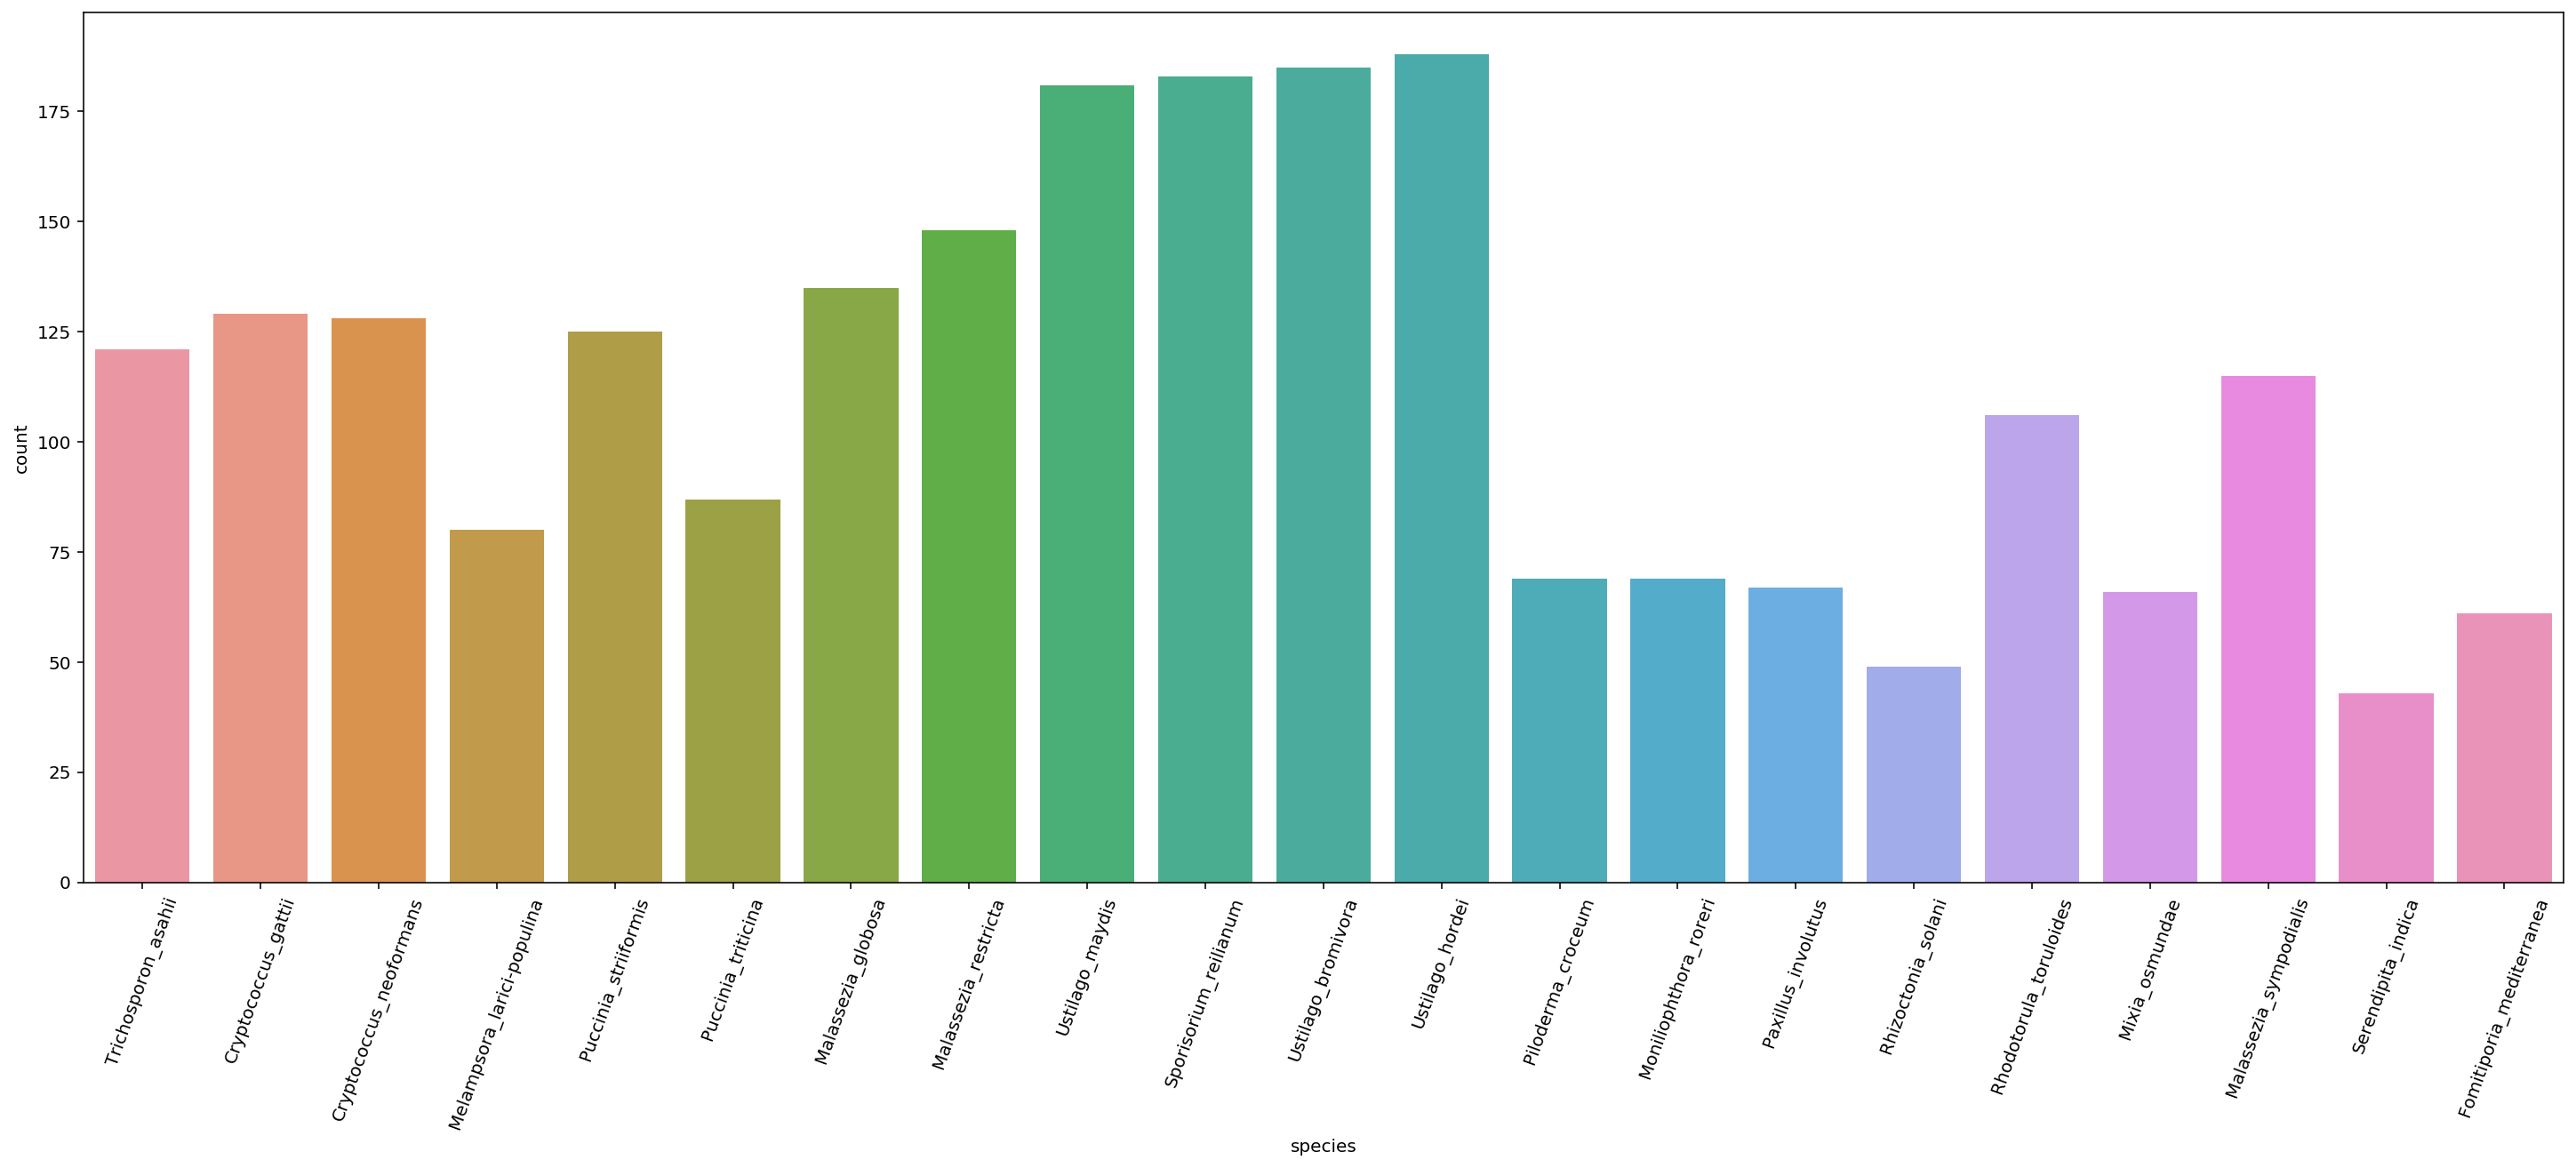

In [35]:
plt.subplots(figsize=(25,9))
g = sns.countplot(r_dd["species"])
g.set_xticklabels(g.get_xticklabels(), rotation=70)

In [36]:
r_dd

,family,branch,p-value,tree,children,species
0,family_19874,Node28,0.00012,"((XP_007271163_1:0.294216738,((KIJ13771_1:0.39...",XP_014181204_1,Trichosporon_asahii
1,family_19874,Node28,0.00012,"((XP_007271163_1:0.294216738,((KIJ13771_1:0.39...",KIR67697_1,Cryptococcus_gattii
2,family_19874,Node28,0.00012,"((XP_007271163_1:0.294216738,((KIJ13771_1:0.39...",XP_012048144_1,Cryptococcus_neoformans
3,family_3151,Node32,0.00000,"(CCA71270_1:0.6925800989999999,(XP_007265603_1...",XP_007418601_1,Melampsora_larici-populina
4,family_3151,Node32,0.00000,"(CCA71270_1:0.6925800989999999,(XP_007265603_1...",POV94377_1,Puccinia_striiformis
...,...,...,...,...,...,...
2330,family_353,Node19,0.03602,"((EUC54641_1:0.810694861,(XP_007262729_1:0.453...",SAM84633_1,Ustilago_bromivora
2331,family_353,Node19,0.03602,"((EUC54641_1:0.810694861,(XP_007262729_1:0.453...",CCF48913_1,Ustilago_hordei
2332,family_2123,Node14,0.00571,"(XP_027482623_1:1.227699243,(EUC54576_1:0.6511...",XP_014176898_1,Trichosporon_asahii
2333,family_2123,Node14,0.00571,"(XP_027482623_1:1.227699243,(EUC54576_1:0.6511...",KIR67571_1,Cryptococcus_gattii


## Proteome interproscan annotations

In [37]:
proteome = glob.glob("tsv/*.tsv")

col_names = ["protein_accession","md5","length","analysis", "signature_accession",
             "signature_description", "start","stop","score","status","date",
             "ip_accesion","ip_description","go","pathway"]

annotations = []

for infile in proteome:
    data = pd.read_csv(infile, sep='\t',names=col_names)
    data["family"] = infile[4:].split(".")[0]
    annotations.append(data)
    
all_annotations = pd.concat(annotations).reset_index()

In [38]:
all_annotations

,index,protein_accession,md5,length,analysis,signature_accession,signature_description,start,stop,score,status,date,ip_accesion,ip_description,go,pathway,family
0,0,XP_018740815.1,862b2a1f5c898650ec5a85b8169ecd3a,384,ProSiteProfiles,PS50850,Major facilitator superfamily (MFS) profile.,57,384,9.889,T,11-11-2019,IPR020846,Major facilitator superfamily domain,NaN,NaN,Malassezia_sympodialis
1,1,XP_018740815.1,862b2a1f5c898650ec5a85b8169ecd3a,384,CDD,cd17327,MFS_FEN2_like,52,376,8.25213E-79,T,11-11-2019,NaN,NaN,NaN,NaN,Malassezia_sympodialis
2,2,XP_018740815.1,862b2a1f5c898650ec5a85b8169ecd3a,384,SUPERFAMILY,SSF103473,NaN,40,371,3.4E-40,T,11-11-2019,IPR036259,MFS transporter superfamily,NaN,NaN,Malassezia_sympodialis
3,3,XP_018740815.1,862b2a1f5c898650ec5a85b8169ecd3a,384,Pfam,PF07690,Major Facilitator Superfamily,63,373,6.6E-19,T,11-11-2019,IPR011701,Major facilitator superfamily,GO:0005887|GO:0055085,NaN,Malassezia_sympodialis
4,4,XP_018740815.1,862b2a1f5c898650ec5a85b8169ecd3a,384,Gene3D,G3DSA:1.20.1250.20,NaN,53,383,2.1E-30,T,11-11-2019,NaN,NaN,NaN,NaN,Malassezia_sympodialis
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1779924,78108,XP_011392368.1,988bc1a9407566dca1a9cba14992b3a2,179,MobiDBLite,mobidb-lite,consensus disorder prediction,159,179,-,T,12-11-2019,NaN,NaN,NaN,NaN,Ustilago_maydis
1779925,78109,XP_011388362.1,2884d85d37482d8b264d45f1b8938fca,153,MobiDBLite,mobidb-lite,consensus disorder prediction,134,153,-,T,12-11-2019,NaN,NaN,NaN,NaN,Ustilago_maydis
1779926,78110,XP_011386780.1,7fac5a327538177200fa3f8f68e1dff8,303,PANTHER,PTHR38409,NaN,9,301,4.8E-68,T,12-11-2019,IPR039960,MDM10-complementing protein 1,GO:0032592|GO:0055088,NaN,Ustilago_maydis
1779927,78111,XP_011386748.1,250ed41600898262ef8ccbdeb51beb4e,164,Pfam,PF07727,Reverse transcriptase (RNA-dependent DNA polym...,2,92,2.8E-17,T,12-11-2019,IPR013103,"Reverse transcriptase, RNA-dependent DNA polym...",NaN,NaN,Ustilago_maydis


The following syntax slices all the proteins under positive selection for the specified species. Next step is to do the enrichment analysis with goatools.

Export `r_dd` dataframe

In [39]:
all_annotations["protein_accession"] = all_annotations["protein_accession"].replace("\.","_",regex=True)

In [40]:
r_dd.to_csv("r_dd.csv")

In [41]:
all_annotations.to_csv("all_ann.csv")

Need to make a new column in the all_ann dataset that tells which proteins match the accessions in the r_dd dataset

In [42]:
all_annotations["ps"] = np.where(all_annotations["protein_accession"].isin(r_dd["children"]), "yes", "no")

Add information of duplicated genes to the dataframe

For this I need to make a new dataframe that includes all the proteins of the duplicated families that follows the shape 1xn where n is the number of total protein duplicates.

In [43]:
fams = pd.read_csv("fam.txt","\s+",header=None)

In [44]:
fams = fams[1].str.split(",",expand=True)

In [45]:
fams.fillna(value=pd.np.nan, inplace=True)

In [46]:
fams

,0,1,2
0,KIR58276.1,NaN,NaN
1,KIR67911.1,NaN,NaN
2,KIR68592.1,NaN,NaN
3,KIR59908.1,NaN,NaN
4,KIR57646.1,NaN,NaN
...,...,...,...
91545,XP_011386124.1,NaN,NaN
91546,XP_011387802.1,NaN,NaN
91547,XP_011387919.1,NaN,NaN
91548,XP_011386703.1,NaN,NaN


In [47]:
fams.dropna(subset=[1])

,0,1,2
612,KIR68447.1,KIR60098.1,NaN
622,KIR58877.1,KIR68586.1,NaN
624,KIR59206.1,KIR68446.1,NaN
654,KIR68402.1,KIR59320.1,NaN
663,KIR57782.1,KIR67298.1,NaN
...,...,...,...
91028,XP_011392146.1,XP_011392724.1,NaN
91189,XP_011392100.1,XP_011392099.1,NaN
91190,XP_011392539.1,XP_011390298.1,NaN
91326,XP_011386002.1,XP_011392141.1,NaN


In [48]:
fams = fams.dropna(subset=[1]).melt().dropna()

In [49]:
fams["value"].to_csv("dups.txt",index=False,header=False)

In [50]:
dups = fams["value"]

In [51]:
#dups = pd.read_csv("ncbi/dups.txt",header=None)

In [52]:
dups = dups.replace("\.","_",regex=True)

In [53]:
all_annotations["dups"] = np.where(all_annotations["protein_accession"].isin(dups), "yes", "no")

## Make associations in the topGO format

In [54]:
all_annotations["go"] = all_annotations["go"].str.replace("|",",")

In [55]:
all_annotations[["protein_accession","go"]].dropna().to_csv("go_mapping.csv", sep="\t", index= False)

## Secretome
Anotate also proteins that show a signal peptide.

In [56]:
secreted_notm = all_annotations[(all_annotations.analysis.str.contains("SignalP_E"))&(all_annotations.signature_accession.str.contains("SignalP-noTM"))].protein_accession

In [57]:
secreted_tm = all_annotations[(all_annotations.analysis.str.contains("SignalP_E"))&(all_annotations.signature_accession.str.contains("SignalP-TM"))].protein_accession

In [58]:
 all_annotations.loc[all_annotations[all_annotations["protein_accession"].isin(secreted_tm)].index]["signal"] = "SignalP-TM" 

In [59]:
all_annotations["signal"]= np.where(all_annotations.protein_accession.isin(secreted_notm),"SignalP-noTM",
                                    (np.where(all_annotations.protein_accession.isin(secreted_tm),"SignalP-TM",np.nan)))

In [60]:
all_annotations[all_annotations.signal == "SignalP-TM"]

,index,protein_accession,md5,length,analysis,signature_accession,signature_description,start,stop,score,status,date,ip_accesion,ip_description,go,pathway,family,ps,dups,signal
103,103,XP_018740690_1,ce1fc295ab1e21438ad3b5521778e710,302,PANTHER,PTHR45856,NaN,86,257,2.0E-28,T,11-11-2019,NaN,NaN,NaN,NaN,Malassezia_sympodialis,no,no,SignalP-TM
104,104,XP_018740690_1,ce1fc295ab1e21438ad3b5521778e710,302,Pfam,PF01764,Lipase (class 3),99,238,2.8E-18,T,11-11-2019,IPR002921,Fungal lipase-like domain,GO:0006629,Reactome: R-HSA-426048,Malassezia_sympodialis,no,no,SignalP-TM
105,105,XP_018740690_1,ce1fc295ab1e21438ad3b5521778e710,302,CDD,cd00519,Lipase_3,42,252,8.17301E-28,T,11-11-2019,NaN,NaN,NaN,NaN,Malassezia_sympodialis,no,no,SignalP-TM
106,106,XP_018740690_1,ce1fc295ab1e21438ad3b5521778e710,302,SignalP_EUK,SignalP-TM,NaN,1,16,-,T,11-11-2019,NaN,NaN,NaN,NaN,Malassezia_sympodialis,no,no,SignalP-TM
107,107,XP_018740690_1,ce1fc295ab1e21438ad3b5521778e710,302,SUPERFAMILY,SSF53474,NaN,41,286,3.01E-29,T,11-11-2019,IPR029058,Alpha/Beta hydrolase fold,NaN,NaN,Malassezia_sympodialis,no,no,SignalP-TM
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1779501,77685,XP_011387899_1,ceffec48bdc46a1d6806df34fece7e4d,249,MobiDBLite,mobidb-lite,consensus disorder prediction,143,184,-,T,12-11-2019,NaN,NaN,NaN,NaN,Ustilago_maydis,no,no,SignalP-TM
1779502,77686,XP_011387899_1,ceffec48bdc46a1d6806df34fece7e4d,249,SignalP_EUK,SignalP-TM,NaN,1,28,-,T,12-11-2019,NaN,NaN,NaN,NaN,Ustilago_maydis,no,no,SignalP-TM
1779503,77687,XP_011387899_1,ceffec48bdc46a1d6806df34fece7e4d,249,MobiDBLite,mobidb-lite,consensus disorder prediction,115,185,-,T,12-11-2019,NaN,NaN,NaN,NaN,Ustilago_maydis,no,no,SignalP-TM
1779894,78078,XP_011389116_1,78932a6505248d94300fab3ab1f79512,189,SignalP_EUK,SignalP-TM,NaN,1,22,-,T,12-11-2019,NaN,NaN,NaN,NaN,Ustilago_maydis,no,no,SignalP-TM


Write dataframe to file

In [61]:
all_annotations.to_csv("all_ann.csv")

In [62]:
all_annotations[all_annotations["ps"]=="yes"].drop_duplicates("family")

,index,protein_accession,md5,length,analysis,signature_accession,signature_description,start,stop,score,status,date,ip_accesion,ip_description,go,pathway,family,ps,dups,signal
179,179,XP_018741687_1,a6a8a48cf97306fc4c502dca004f536a,1013,Gene3D,G3DSA:3.40.1060.10,NaN,237,351,1.6E-34,T,11-11-2019,IPR015932,"Aconitase, domain 2",NaN,KEGG: 00020+4.2.1.3|KEGG: 00630+4.2.1.3|KEGG: ...,Malassezia_sympodialis,yes,no,nan
36520,63,SJX64558_1,7a847225ac9487bcad3effdc6daaa760,1121,MobiDBLite,mobidb-lite,consensus disorder prediction,126,174,-,T,11-11-2019,NaN,NaN,NaN,NaN,Sporisorium_reilianum,yes,no,nan
116449,135,XP_016271952_1,3fd7cd03253ef2084e5486db2cbf786e,1872,SUPERFAMILY,SSF101447,NaN,1161,1639,9.02E-71,T,12-11-2019,NaN,NaN,NaN,NaN,Rhodotorula_toruloides,yes,no,nan
201927,0,XP_014566219_1,a368e61035af0a0e7aeac60d1b5eb61d,741,SMART,SM00487,NaN,64,251,1.2E-29,T,11-11-2019,IPR014001,"Helicase superfamily 1/2, ATP-binding domain",NaN,NaN,Mixia_osmundae,yes,no,nan
268275,816,KIR68367_1,ad4a051e049cd75f98f25e9edc2b4803,491,Gene3D,G3DSA:3.20.20.70,NaN,58,335,2.0E-101,T,11-11-2019,IPR013785,Aldolase-type TIM barrel,GO:0003824,NaN,Cryptococcus_gattii,yes,no,nan
335352,1052,XP_014177475_1,e2f7933eed7ff971d0e7e0dd1c5c2bdf,360,CDD,cd00354,FBPase,31,350,5.48762E-177,T,12-11-2019,IPR000146,"Fructose-1,6-bisphosphatase class 1","GO:0005975,GO:0016791",KEGG: 00010+3.1.3.11|KEGG: 00030+3.1.3.11|KEGG...,Trichosporon_asahii,yes,no,nan
412350,1052,POW15726_1,9468f6ec8d62762050f9c9faaec0ff2a,629,Gene3D,G3DSA:3.30.559.40,NaN,47,613,4.5E-179,T,12-11-2019,IPR042232,"Choline/Carnitine o-acyltransferase, domain 1",NaN,NaN,Puccinia_striiformis,yes,no,nan
506509,1331,SAM79781_1,cfd3b354d7b0779af2595086cb9533c1,4205,MobiDBLite,mobidb-lite,consensus disorder prediction,1660,1678,-,T,12-11-2019,NaN,NaN,NaN,NaN,Ustilago_bromivora,yes,no,nan
585963,530,XP_007406369_1,4be4079fe5d75806fdbfbfabc2faa135,1179,CDD,cd01423,MGS_CPS_I_III,1019,1140,3.70324E-29,T,12-11-2019,NaN,NaN,NaN,NaN,Melampsora_larici-populina,yes,no,nan
678924,284,XP_027482890_1,05894cb4547adbd72c2685705d3f7c5e,592,MobiDBLite,mobidb-lite,consensus disorder prediction,489,592,-,T,11-11-2019,NaN,NaN,NaN,NaN,Malassezia_restricta,yes,no,nan
